In [5]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np

print(tf.__version__)


1.13.1


## IMDB数据集下载和探索

数据集来源为IMDB的50000条电影评论，其中25000条消极评论和25000条积极评论。

In [6]:
# 从tensorflow加载IMDB数据集 
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 10s 1us/step


In [17]:
len(train_data[0]), len(train_data[1]), len(train_data[2])


(218, 189, 141)

In [23]:
print(train_labels[0], train_labels[1], train_labels[2])

1 0 0


In [19]:
# 字典：将数字转为单词
word_index = imdb.get_word_index()

word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0 # 用来将每一个sentence扩充到同等长度
word_index["<START>"] = 1
word_index["<UNK>"] = 2 
word_index["UNUSED"] = 3

reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])
 
# 转译为原句
def decode_review(text):
    return ' '.join([reverse_word_index.get(i,'?') for i in text])
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

影评（整数数组）必须转换为张量，然后才能馈送到神经网络中。
我们可以通过以下两种方法实现这种转换：

1.对数组进行独热编码，将它们转换为由 0 和 1 构成的向量。例如，序列 [3, 5] 将变成一个 10000 维的向量，除索引 3 和 5 转换为 1 之外，其余全转换为 0。然后，将它作为网络的第一层，一个可以处理浮点向量数据的密集层。不过，这种方法会占用大量内存，需要一个大小为 num_words * num_reviews 的矩阵。

2.可以填充数组，使它们都具有相同的长度，然后创建一个形状为 max_length * num_reviews 的整数张量。我们可以使用一个能够处理这种形状的嵌入层作为网络中的第一层。

In [24]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [25]:
len(train_data[0]), len(train_data[1]), len(train_data[2])

(256, 256, 256)

构建模型
神经网络通过堆叠层创建而成，这需要做出两个架构方面的主要决策：

要在模型中使用多少个层？
要针对每个层使用多少个隐藏单元？
在本示例中，输入数据由字词-索引数组构成。
要预测的标签是 0 或 1。

构建模型

输入数据是单词组合，标签是0或者1
先进行数据稀疏稠密化，因为sequence里面的word_index值是[0~10000]内稀疏的，所以将每一个单词用一个16维的向量代替；input(1024,256)output(1024,256,16)
再通过均值的池化层，将每一个sequence做均值，类似于将单词合并 ;input(1024,256,16),output(1024,16)
全连接层采用relu激活函数;input(1024,16),output(1024,16)
全连接层采用sigmoid激活函数；input(1024,16),output(1024,1)

In [26]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


按顺序堆叠各个层以构建分类器：

第一层是 Embedding 层。该层会在整数编码的词汇表中查找每个字词-索引的嵌入向量。模型在接受训练时会学习这些向量。这些向量会向输出数组添加一个维度。生成的维度为：(batch, sequence, embedding)。
接下来，一个 GlobalAveragePooling1D 层通过对序列维度求平均值，针对每个样本返回一个长度固定的输出向量。这样，模型便能够以尽可能简单的方式处理各种长度的输入。
该长度固定的输出向量会传入一个全连接 (Dense) 层（包含 16 个隐藏单元）。
最后一层与单个输出节点密集连接。应用 sigmoid 激活函数后，结果是介于 0 到 1 之间的浮点值，表示概率或置信水平。

隐藏单元
上述模型在输入和输出之间有两个中间层（也称为“隐藏”层）。输出（单元、节点或神经元）的数量是相应层的表示法空间的维度。换句话说，该数值表示学习内部表示法时网络所允许的自由度。

如果模型具有更多隐藏单元（更高维度的表示空间）和/或更多层，则说明网络可以学习更复杂的表示法。不过，这会使网络耗费更多计算资源，并且可能导致学习不必要的模式（可以优化在训练数据上的表现，但不会优化在测试数据上的表现）。这称为过拟合，我们稍后会加以探讨。

损失函数和优化器
模型在训练时需要一个损失函数和一个优化器。由于这是一个二元分类问题且模型会输出一个概率（应用 S 型激活函数的单个单元层），因此我们将使用 binary_crossentropy 损失函数。

该函数并不是唯一的损失函数，例如，您可以选择 mean_squared_error。但一般来说，binary_crossentropy 更适合处理概率问题，它可测量概率分布之间的“差距”，在本例中则为实际分布和预测之间的“差距”。

稍后，在探索回归问题（比如预测房价）时，我们将了解如何使用另一个称为均方误差的损失函数。

现在，配置模型以使用优化器和损失函数：

In [27]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [28]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
15000/15000 [==============================] - 4s 290us/sample - loss: 0.6916 - acc: 0.5507 - val_loss: 0.6893 - val_acc: 0.6036
Epoch 2/40
15000/15000 [==============================] - 2s 164us/sample - loss: 0.6850 - acc: 0.6928 - val_loss: 0.6809 - val_acc: 0.6981
Epoch 3/40
15000/15000 [==============================] - 2s 155us/sample - loss: 0.6718 - acc: 0.7403 - val_loss: 0.6647 - val_acc: 0.7482
Epoch 4/40
15000/15000 [==============================] - 3s 168us/sample - loss: 0.6492 - acc: 0.7557 - val_loss: 0.6392 - val_acc: 0.7751
Epoch 5/40
15000/15000 [==============================] - 2s 164us/sample - loss: 0.6165 - acc: 0.7914 - val_loss: 0.6055 - val_acc: 0.7906
Epoch 6/40
15000/15000 [==============================] - 3s 170us/sample - loss: 0.5754 - acc: 0.8187 - val_loss: 0.5662 - val_acc: 0.8033
Epoch 7/40
15000/15000 [==============================] - 2s 1

In [29]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 2s 66us/sample - loss: 0.3360 - acc: 0.8711
[0.33595064166069033, 0.87108]


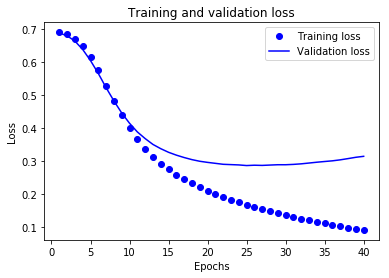

In [32]:
history_dict = history.history
history_dict.keys()

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



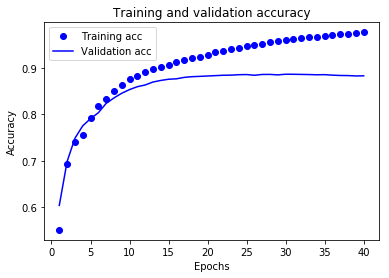

In [33]:

plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## THUCNews

In [34]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np

base_dir = 'D:\1python_workspace\some work\datawhale_NLP\cnews'
train_dir = os.path.join(base_dir, 'cnews.train.txt')
test_dir = os.path.join(base_dir, 'cnews.test.txt')
val_dir = os.path.join(base_dir, 'cnews.val.txt')
vocab_dir = os.path.join(base_dir, 'cnews.vocab.txt')

print ('train_dir',train_dir)
print ('test_dir',test_dir)
print ('val_dir',val_dir)
print ('vocab_dir',vocab_dir)

train_dir D:python_workspace\some work\datawhale_NLP\cnews\cnews.train.txt
test_dir D:python_workspace\some work\datawhale_NLP\cnews\cnews.test.txt
val_dir D:python_workspace\some work\datawhale_NLP\cnews\cnews.val.txt
vocab_dir D:python_workspace\some work\datawhale_NLP\cnews\cnews.vocab.txt


In [ ]:
def build_vocab(train_dir, vocab_dir, vocab_size=5000):
    """根据训练集构建词汇表，存储"""
    data_train, _ = read_file(train_dir)  ##data_train存储的是一个一个的文本
    print(data_train)
 
    all_data = []
    for content in data_train:
        all_data.extend(content)
 
    counter = Counter(all_data)
    count_pairs = counter.most_common(vocab_size - 1)
    words, _ = list(zip(*count_pairs))
    # 添加一个 <PAD> 来将所有文本pad为同一长度
    words = ['<PAD>'] + list(words)
open_file(vocab_dir, mode='w').write('\n'.join(words) + '\n')

def read_file(filename):
    """读取文件数据"""
    contents, labels = [], []
    with open_file(filename) as f:
        for line in f:
            try:
                label, content = line.strip().split('\t')
                if content:
                    contents.append(list(native_content(content)))
                    labels.append(native_content(label))
            except:
                pass
    return contents, labels


def open_file(filename, mode='r'):
    """
    常用文件操作，可在python2和python3间切换.
    mode: 'r' or 'w' for read or write
    """
    if is_py3:
        return open(filename, mode, encoding='utf-8', errors='ignore')
    else:
        return open(filename, mode)
    

def read_category(categories):
    """读取分类目录，固定"""
    categories = ['入户盗窃', '扒窃', '一般盗窃']
    categories = [native_content(x) for x in categories]
 
    cat_to_id = dict(zip(categories, range(len(categories)))) #将类别分别进行id的转换
 
return categories, cat_to_id


def read_vocab(vocab_dir):
    """读取词汇表"""
    with open_file(vocab_dir) as fp:
        # 如果是py2 则每个值都转化为unicode
        words = [native_content(_.strip()) for _ in fp.readlines()]
    word_to_id = dict(zip(words, range(len(words))))
    return words, word_to_id


